Para exemplificar o uso das implementações da DFT em python, será realizado um exercício de análise de sinais de áudio.

O primeiro exercício consiste em analisar o espectro de um sinal de áudio puro.

O segundo, buscando avaliar o comportamento da STFT implementada no scipy.signal. Para esse exercício será analisado o espectrograma de um sinal de audio que sofre com um ruído de decaimento exponencial.

Os códigos, requirements.txt e arquivos de roteiro da apresentação podem ser encontrados em https://github.com/leandroassis/DFT.

In [469]:
import numpy as np
from scipy.fft import fft, fftshift, ifft, rfft, irfft, fftfreq, fftn
from scipy.signal import stft, istft, fftconvolve
import matplotlib.pyplot as plt
from scipy.io import wavfile
import time


### A DFT em Python

In [470]:
# Carrega o arquivo de áudio
sampling_rate, sinal = wavfile.read('Practice-Pad-Single-Stroke.wav')

# esse sinal de áudio tem N amostras, amostradas com frequência de sampling_rate
print(f'Número de amostras: {len(sinal)}')
print(f'Frequência de amostragem: {sampling_rate} Hz')

Número de amostras: 23994
Frequência de amostragem: 44100 Hz


/tmp/ipykernel_10470/1877645677.py:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sampling_rate, sinal = wavfile.read('Practice-Pad-Single-Stroke.wav')


#### DFT

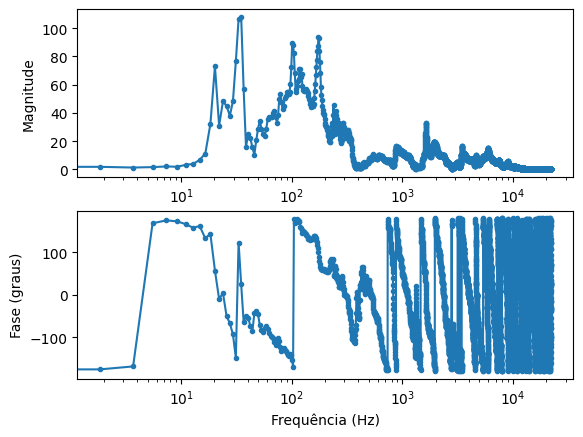

In [471]:
# plotando o espectro de frequências do sinal de áudio

# tamanho do sinal
N = len(sinal)

# Determina a FFT
fft_sinal = fftshift(fft(sinal, N)) # valores complexos das frequências
frequencias = fftshift(fftfreq(N, 1/sampling_rate)) # frequências de cada componente

# Plot das componentes de frequência
plt.figure()
plt.subplot(2,1,1)
plt.plot(frequencias, np.abs(fft_sinal)/N, '.-')
plt.ylabel('Magnitude')
plt.xlabel('Frequência (Hz)')
plt.xscale('log')

plt.subplot(2,1,2)
plt.plot(frequencias, np.degrees(np.angle(fft_sinal)), '.-')
plt.ylabel('Fase (graus)')
plt.xlabel('Frequência (Hz)')
plt.xscale('log')
plt.show()

O gráfico acima é o espectro de frequência do sinal de áudio feito a partir da DFT do sinal. Com os valores retornados pela DFT pode-se extrair o módulo e a fase do sinal. O módulo é o que representa a magnitude do sinal, enquanto a fase representa a posição do sinal no tempo. O gráfico acima mostra que o sinal possui uma componente de frequência mais significativa em torno de 40Hz. Pode-se também observar que as demais componentes de frequência do sinal de áudio com maior magnitude estão localizadas entre 20Hz e 300Hz, com pico em 40Hz (aproximadamente), isso se dá pois o instrumento musical usado para gerar essa frequência possui um som mais grave.

Ou seja, a partir da DFT do sinal pode-se analisar quais são as componentes de frequência mais significativas do sinal e seus respectivos desvios angulares (suas características, em resumo). Isso é útil em diversas áreas da tecnologia pois podemos simplificar o sinal apenas nas componentes mais relevantes e assim, reduzir o tamanho do sinal, sem perder muita informação para a posterior reconstrução do sinal de áudio no tempo. Essa aplicação é utilizada na telecomunicação (para envio de voz), compressão de dados e em diversas outras áreas. 



Note que com quanto mais amostras realizarmos a DFT do sinal, em mais exponencias complexas o sinal poderá ser decomposto, e portanto representará com mais precisão o valor real. No exemplo a seguir o gráfico será plotado com apenas um décimo do número de amostras do sinal de áudio.

Para reduzir o número de amostras, irei remover 9 a cada 10 amostras do sinal de áudio e dividir a sample_rate por 10.

In [472]:
# criação do novo sinal a partir do sinal antigo
novo_sinal = []
count = 0
for idx, amostra in enumerate(sinal):
    if count == 9:
        novo_sinal.append(amostra)
        count = 0
        continue
    count += 1

len(sinal), len(novo_sinal)

(23994, 2399)

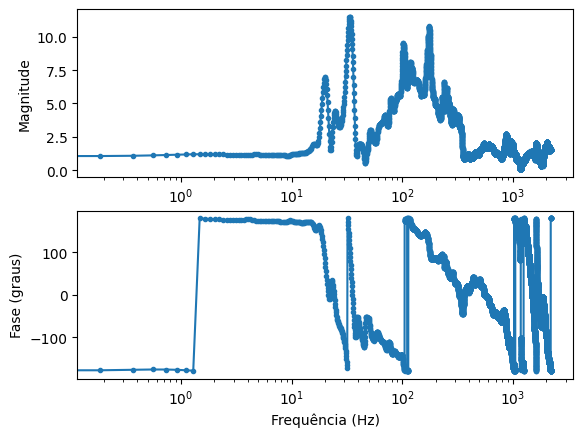

In [473]:
# plotando o espectro de frequências do novo sinal de áudio

# Determina a FFT
fft_novo_sinal = fftshift(fft(novo_sinal, N)) # valores complexos das frequências
frequencias = fftshift(fftfreq(N, 10/sampling_rate)) # frequências de cada componente

# Plot das componentes de frequência
plt.figure()
plt.subplot(2,1,1)
plt.plot(frequencias, np.abs(fft_novo_sinal)/N, '.-')
plt.ylabel('Magnitude')
plt.xlabel('Frequência (Hz)')
plt.xscale('log')

plt.subplot(2,1,2)
plt.plot(frequencias, np.degrees(np.angle(fft_novo_sinal)), '.-')
plt.ylabel('Fase (graus)')
plt.xlabel('Frequência (Hz)')
plt.xscale('log')
plt.show()

#### STFT

Para demonstrar a STFT, vamos analisar o espectrograma de um sinal de áudio que sofre com um ruído de decaimento exponencial. O sinal de áudio é o mesmo do exercício anterior, porém com um ruído de decaimento exponencial.

[-5.17653357e+003  9.27258245e+003 -2.30850790e+004 ...  3.72467892e-205
  5.16704203e-205 -1.59635082e-204]
[-12 -51  17 ...  -6  -3  -8]
[-5.18853357e+03  9.22158245e+03 -2.30680790e+04 ... -6.00000000e+00
 -3.00000000e+00 -8.00000000e+00]


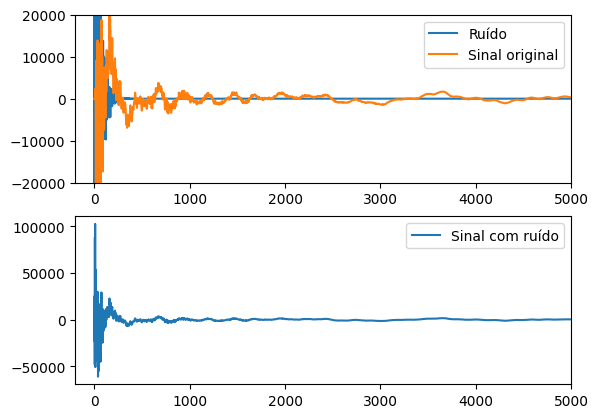

In [474]:
rng = np.random.default_rng()

duracao = np.arange(N) # duração do sinal em segundos
ruido = rng.normal(scale=sampling_rate, size=duracao.shape) # ruído branco "aleatório"
ruido *= np.exp(-duracao/50) # decaimento exponencial adicionado ao ruído

sinal_ruido = sinal + ruido

print(ruido)
print(sinal)
print(sinal_ruido)

plt.subplot(2,1,1)
plt.plot(duracao, ruido, label='Ruído')
plt.plot(duracao, sinal, label='Sinal original')
plt.xlim(-200, 5000)
plt.ylim(-20000, 20000)
plt.legend()
plt.subplot(2,1,2)
plt.plot(duracao, sinal_ruido, label='Sinal com ruído')
plt.xlim(-200, 5000)
plt.legend()
plt.show()

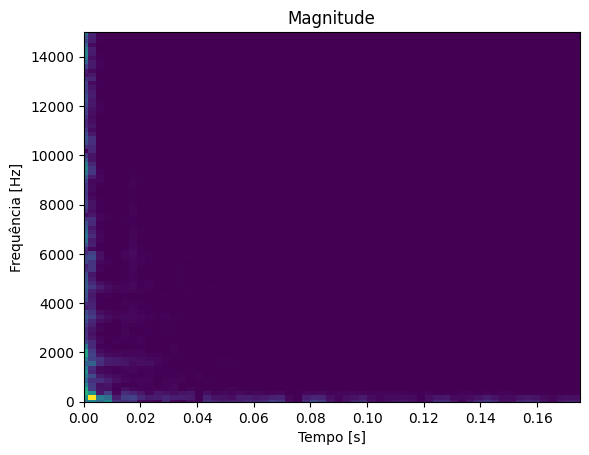

In [475]:
# agora faz-se a stft para analisar as componentes espectrais ao longo do tempo

f, t, Zxx = stft(sinal_ruido, sampling_rate)
plt.pcolormesh(t, f, np.abs(Zxx))
plt.title('Magnitude')
plt.ylabel('Frequência [Hz]')
plt.xlabel('Tempo [s]')
plt.xlim(0, 0.175)
plt.ylim(0, 15000)
plt.show()

Analisando o mapa de calor criado a partir da STFT é possível ver que nos primeiros segundos existe muitas componentes de frequência alta por conta do ruído branco introduzido, entretando com o decair do ruído, as componentes de frequência do sinal de áudio original (frequência mais baixas) começa a ser a única componente de frequência a ser percebida.

Note que o ponto amarelo forte no inicio do gráfico significa que a magnitude do sinal ainda é maior que a magnitude das componentes do ruído, apesar do ruído introduzir novas componentes de frequência que não existiam no sinal original.

#### Comparação de Eficiência Computacional

Para essa comparação verifica-se quais implementações da DFT possuem mais eficiência computacional. Para isso, será analisado o tempo de execução de cada implementação para um sinal aleatório. Infelizmente não é possível testar a implementação da DFT feita a mão para um sinal de áudio, pois o gerenciamento de memória é tão ineficiente que o computador trava. Por isso, será testado para um sinal aleatório.

As implementações testadas são:

1. scipy.fft
2. numpy.fft
3. scipy.rfft

Além disso, testa-se uma implementação da DFT com um algoritmo puramente baseada na equação matematica, sem uso do FFT.

In [480]:

# função dft desenvolvida baseada na fórmula matemática
def dft(signal):
    N = len(signal)
    n = np.arange(N)
    k = n.reshape((N, 1))
    e = np.exp(-2j * np.pi * k * n / N)
    return np.dot(e, signal)

def teste_ffts(signal):

    print("Testando scipy.fft.fft:")
    start_time = time.time()
    fft_result = fft(signal)
    end_time = time.time()
    print("Tempo de execução: {:.6f} segundos".format(end_time - start_time))
    print()

    print("Testando numpy.fft.fft:")
    start_time = time.time()
    fft_result_npy = np.fft.fft(signal)
    end_time = time.time()
    print("Tempo de execução: {:.6f} segundos".format(end_time - start_time))
    print()

    print("Testando implementação da DFT:")
    start_time = time.time()
    dft_result = dft(signal)
    end_time = time.time()
    print("Tempo de execução: {:.6f} segundos".format(end_time - start_time))
    print()

    print("Resultados das FFTs:")
    print("fft_result: ", fft_result)
    print("dft_result: ", dft_result)

    print()

    print("Testando scipy.fft.fftn (512x512):")
    signal_2d = np.random.random((512, 512))
    start_time = time.time()
    fftn_result = fftn(signal_2d)
    end_time = time.time()
    print("Tempo de execução: {:.6f} segundos".format(end_time - start_time))
    print()

signal = np.random.random(4096)  # Sinal aleatório de tamanho 4096
teste_ffts(signal)


Testando scipy.fft.fft:
Tempo de execução: 0.001940 segundos

Testando numpy.fft.fft:
Tempo de execução: 0.000337 segundos

Testando implementação da DFT:
Tempo de execução: 3.186551 segundos

Resultados das FFTs:
fft_result:  [ 2.06720826e+03 -0.j         -1.82684215e+00 +7.99619366j
  2.26539058e+01 -1.44572874j ... -2.82402108e+00-13.50324962j
  2.26539058e+01 +1.44572874j -1.82684215e+00 -7.99619366j]
dft_result:  [ 2.06720826e+03 +0.j         -1.82684215e+00 +7.99619366j
  2.26539058e+01 -1.44572874j ... -2.82402108e+00-13.50324962j
  2.26539058e+01 +1.44572874j -1.82684215e+00 -7.99619366j]

Testando scipy.fft.fftn (512x512):
Tempo de execução: 0.009789 segundos



Os resultados acima demonstram como o uso do FFT pode ser mais eficiente computacionalmente. A implementação da DFT com o algoritmo puramente matemático é a mais lenta, seguida pela implementação da DFT do numpy. A implementação mais eficiente é a da DFT do scipy com o uso do FFT.

Com o uso do algoritmo FFT, a determinação da DFT ocorre 1650 vezes mais rápido. É possível prever que provavelmente esse tempo de cresce de forma exponencial com o aumento do número de amostras do sinal.